# Implementation of vCC

The following is VQE code using the scipy.optimize.minimize in the classical optimisation loop, and the vCC ansatz that uses lcu and fpoaa functions from _vcc_lcu for state preparation.

In [1]:
import numpy as np                          # for rank_1_projector and other custom matrices
import math
import matplotlib.pyplot as plt
from collections import Counter

from projectq import MainEngine
from projectq.ops import H, Ry, Rx, X, Y, Z, R, Ph, All, Measure, ControlledGate
                                            # Ph for global phase
                                            # R is for phase gates
from projectq.ops._basics import SelfInverseGate
                                            # because they don't have a named identity
        
from projectq.meta import Dagger, Compute, Uncompute, Control

from projectq.ops import QubitOperator
from openfermion.ops import FermionOperator

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner

from _vcc_lcu import *

In [20]:
def my_jordan_wigner(fermion_op):
    qubit_op = jordan_wigner(fermion_op)
    good_qop = QubitOperator()
    for term in qubit_op.terms:
        good_qop += QubitOperator(term, qubit_op.terms[term])
    return good_qop

def vcc_ansatz(eng, occ, unocc, n_orbitals, n_electrons, terms, amps):
    ###################################################
    # CAN YOU DO EACH TERM FOR ITS OWN NUMBER OF REPS #
    # INSTEAD OF MAX REP? WILL THAT SAVE TIME?        #
    ###################################################
    """Prepares vccsd ansatz wavefuction
    Args:
        simulator engine
        quregs occ+unocc to be prepared to target state
        number of orbitals
        number of electrons
        list of cc terms to apply
        list of cc amplitudes
    Return:
        <in ProjectQ, returning quregs causes simulator errors, so just setting a qureg here>
    """
    cc_trial = occ+unocc
    # operator for making Hartree-Fock initial state |11...10...0>
    # a^+ ---> sigma_-, so |vac> ---> 0 = unoccupied; _occ_&_unocc_
    hf_str = tuple((index, 'X') for
                              index in range(n_electrons))
    hf_init_op = QubitOperator(hf_str, 1.0)
#     print(hf_init_op)
    
    # Allocate LCU control reg - depends on excitation order trunc
    trunc = 2
    ctrl_dim = 2*trunc + 1
    ctrl = eng.allocate_qureg(ctrl_dim)
    # the lcu algo takes the state [ctrl|occ|unocc]
    cc_lcu = ctrl+cc_trial
                
    # save the max of all amps to determine fpoaa depth
    t_max = np.amax([abs(x) for x in amps])
    # and convert amps to lists of nonzeros, with indices, coeft, and number of time slices
    time_slicing_threshold = 0.05
    # save number of nonzeros for later use
    n_terms = np.count_nonzero(amps)
    
    # set success probability level for LCU steps, p_succ = 1-eps
    # eps in our method depends on the max number of 'time' slices 
    # and the total number of terms, as eps = 1/CrM
    # this give overall succ probability of the method as ~ (1/e)^1/C, in theory
    # C=5 gives p > 0.81
    C = 10
    r = math.ceil(t_max/time_slicing_threshold)
#     print('max_r = {}'.format(r))
    eps = 1.0/(C*r*n_terms)
#     print('eps = {}'.format(eps))
    
    # fpoaa depth k => 3^k = (log p_fail)/(log 2t_max)
    fpoaa_queries = math.log(eps, 10)/math.log(2*t_max, 10)
    if (fpoaa_queries>=3):
        fpoaa_depth = math.ceil(math.log(fpoaa_queries,3))
    else:
        fpoaa_depth = 0    
#     print('fpoaa_depth = {}'.format(fpoaa_depth))
    
    # Apply lcu term by term, first all singles, then all doubles
    # Loop over this until success
    # start from top every time LCU+post fails
    done = False
    num_tarings = 0
    while(not done):
        # tare to all zeros state (when picking up from failed LCU)
        for i in range(0,n_orbitals+ctrl_dim):
            Measure | cc_lcu[i]
            if(bool(cc_lcu[i])):
                X | cc_lcu[i]
            num_tarings += 1
        # set unocc orbitals to 1 (0 = occ)
        eng.flush()
        hf_init_op | occ

        for term in terms:
            idx = terms[term]
            t = amps[idx]
            if not t:
                continue
            list_u = []
            term_id = [int(s) for s in term.split(',')]
            if len(term_id) == 2:
                i, j = sorted(term_id)
                op_str = str(j)+'^'+' '+str(i)
                coefts = [0.25*t/r for x in range(4)]
                coefts = np.concatenate(([1.0], coefts))
    #             print('\n LCU coefficients in singles term {}{}, and the lcu'.format(i, j))
    #             print(coefts)
    #             print(list_u)
            elif len(term_id) == 4:
                i,j,k,l = sorted(term_id)
                op_str = str(k)+'^'+' '+str(l)+'^'+' '+str(j)+' '+str(i)
                coefts = [0.0625*t/r for x in range(16)]
                coefts = np.concatenate(([1.0], coefts))
            
            fer_op = FermionOperator(op_str, 1.0)
            qub_op = QubitOperator('', 1.0) + my_jordan_wigner(fer_op)
            for term in qub_op.terms:
                coeft = qub_op.terms[term]/abs(qub_op.terms[term])
                list_u += [QubitOperator(term, coeft)]
        
            if not list_u:
                print('lcu term {} is empty!!'.format(op_str))
            for i in range(0, r):
                lcu(eng, list_u, coefts, ctrl, cc_trial, ctrl_dim, n_orbitals, fpoaa_depth)
                eng.flush()
                done = bool(postselect(ctrl, ctrl_dim))
                if not done:
                    break
    
#         if done:
#             print('Finished doubles...')
            
#     print('Had to repeat {} times'.format(num_tarings))
    # flush all gates
    eng.flush()

def cc_quantum_coprocessor(amps, *ccargs):
    """
    Arguments:
        theta (float): variational parameters for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the trial wavefunction for parameter theta
    """
    # unpack arguments
    hamiltonian = ccargs[0]
    n_orbitals = ccargs[1]
    n_electrons = ccargs[2]
    terms = ccargs[3]
    eng = ccargs[4]
#     print('\n The hamiltonian they gave me is:\n')
#     print(hamiltonian)
    n_unocc = n_orbitals - n_electrons
    
    unocc = eng.allocate_qureg(n_unocc)
    occ = eng.allocate_qureg(n_electrons)
    cc_trial = occ+unocc    
    
    vcc_ansatz(eng, occ, unocc, n_orbitals, n_electrons, terms, amps)
#     print("-----Amplitudes of CC_trial state----")
#     print_probabilities(eng, cc_lcu, n_orbitals+ctrl_dim)
    # Calculate the energy.
    # ProjectQ simulator can directly return expectation values
    # In reality need to implement Hamiltonian averaging term-wise
    energy = eng.backend.get_expectation_value(hamiltonian, cc_trial)
    print('Measured trial energy = {}'.format(energy))
    # Measure all to satisfy projectq simulator
    eng.flush()
    All(Measure) | cc_trial
    eng.flush()
    return energy

In [21]:
# Build a matrix out of QubitOperator
def get_hamiltonian_matrix(n, ham_op):
        I = [[1,0],[0,1]]
        X = [[0,1],[1,0]]
        Y = [[0,-1j],[1j,0]]
        Z = [[1,0],[0,-1]]
        hamiltonian = np.zeros((2**n, 2**n), dtype=np.complex128)
        for term in ham_op.terms:
            string = [I] * n
            for letter in term:
                if letter[1] != I:
                    if letter[1] == 'X':
                        string[letter[0]] = X
                    if letter[1] == 'Y':
                        string[letter[0]] = Y
                    if letter[1] == 'Z':
                        string[letter[0]] = Z
            temp = string[0]
            for i in range(1, n):
                temp = np.kron(temp, string[i])
            hamiltonian += temp*ham_op.terms[term]
        return hamiltonian


In [66]:
# To use pygmo, primarily for parallelisation of the clasical optimisation
import pygmo
from pygmo.problems import base
from pygmo import algorithm, island

class my_problem(base):
    """
    USAGE: my_problem(dim=10)

    * dim problem dimension
    """
    def __init__(self, n_elec, n_orbs, terms, hamiltonian):
        # First we call the constructor of the base class telling PyGMO
        # what kind of problem to expect ('dim' dimensions, 1 objective, 0 contraints etc.)
        super(my_problem,self).__init__(dim)

        # We set the problem bounds (in this case equal for all components)
        self.set_bounds(-5.12, 5.12)
        
        # vcc specific problem parameters
        self.n_elec = n_elec
        self.n_orbs = n_orbs
        self.terms = terms
        self.hamiltonian = hamiltonian

    # Reimplement the virtual method that defines the objective function.
    def _objfun_impl(self, x):

        # Compute the vccsd energy
        f = cc_quantum_coprocessor(x.amps, x.args)

        # Note that we return a tuple with one element only. In PyGMO the objective functions
        # return tuples so that multi-objective optimization is also possible.
        return (f, )

    # Finally we also reimplement a virtual method that adds some output to the __repr__ method
    def human_readable_extra(self):
        return "\n\t Problem dimension: " + str(self.__dim)

ModuleNotFoundError: No module named 'pygmo.problems'

In [22]:
# %%capture printed_output
# capture output to object to display later
# so that notebook can be closed and then output seen later

from numpy import linspace
import collections
from time import time
from scipy.optimize import minimize, basinhopping, differential_evolution

from _ccsd_amps import *   

def vqe_classical_processor(eng, molecular_details, r_min, r_max, n_pts):
    
    """
    Read MolecularData from HDF5 output of OpenFermion-Psi4
    Populate bond_lengths, extract hamiltonian
    """    
    vccsd_energies = []
    evals_ham_matrix = []
    evect_ham_matrix = []
    psi4_ccsd_energies = []
    times = []
    vccsd_amplitudes = []
    bond_lengths = linspace(r_min, r_max, n_pts)    
    
    folder = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/'
    
    for i in range(n_pts):
        file_i = folder + molecular_details + str(bond_lengths[i])

        # Load data from HDF5 computed using Openfermion-Psi4
        molecule = MolecularData(filename=file_i)
        n_orbs = molecule.n_qubits
        n_elec = molecule.n_electrons
        psi4_ccsd_energies.append(molecule.ccsd_energy)
        nuke_repulsion = molecule.nuclear_repulsion
        classical_gs = molecule.canonical_orbitals
#         print('# orbitals = {} and # electrons = {}'.format(n_orbs, n_elec))

        # Extract initial guesses for CCSD single and double amplitudes
        # stored as numpy arrays
        # 1) MolecularData not storing MP2 amplitudes.. 2) faster convergence 
        ccsd_single_init = molecule.ccsd_single_amps
        ccsd_double_init = molecule.ccsd_double_amps
#         print(ccsd_single_init.shape)
#         print(ccsd_double_init.shape)
#         ccsd_single_init = np.zeros((4,4))
#         ccsd_single_init = np.random.rand(4,4)
#         ccsd_single_init = np.multiply(ccsd_single_init, 0)
#         ccsd_double_init = np.zeros((4,4,4,4))
#         ccsd_double_init[0,1,2,3] = 0.06
    
        terms = term_list(n_elec, n_orbs)
        print(terms)
        amps = populate_term_list(
            ccsd_single_init, ccsd_double_init, terms, n_elec)
        if i:
            amps = vccsd_amplitudes[i-1]

        # Convert hamiltonian to QubitOperator using JW
        molecule_qubit_hamiltonian = my_jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
        # in QisKit, the constant term has nuclera repulsion energy included; trying same thing here
        molecule_qubit_hamiltonian.terms[()] = molecule_qubit_hamiltonian.terms[()] - nuke_repulsion

        
        hamiltonian_matrix = get_hamiltonian_matrix(n_orbs, molecule_qubit_hamiltonian)
        energies, vecs = np.linalg.eig(hamiltonian_matrix)
        print('ground energy and state by diagonalising the hamiltonian:')
        ground_energy = np.amin(energies)
        evals_ham_matrix.append(ground_energy)
        print(ground_energy)
        gs_idx = np.where(energies==ground_energy)
        diag_gs = vecs[gs_idx]
        evect_ham_matrix.append(diag_gs)
        print(f'diagonalised ground state: {diag_gs}')
        print(f'Psi4 ground state: {classical_gs}')
#         print(state)

        # Classical local optimisation loop using scipy.optimize.minimize
        # for variational parameters theta (= CC amplitudes here)
        # Can pass different scipy optimizer options: Brent, Golden, Bounded
        start = time()
        minimum = minimize(cc_quantum_coprocessor, amps,
                           args=(molecule_qubit_hamiltonian, n_orbs, n_elec, terms, eng), 
                           method='Nelder-Mead', options={'xatol':1e-3, 'fatol':1e-3, 'adaptive':True}) # 
#         minimum = basinhopping(cc_quantum_coprocessor, amps,
#                            minimizer_kwargs={'method':'Nelder-Mead', 'args':(molecule_qubit_hamiltonian, n_orbs, n_elec, terms, eng)}) # 
#         bounds = [(-0.2, 0.2)]*len(terms)
#         minimum = differential_evolution(cc_quantum_coprocessor, bounds,
#                            args=(molecule_qubit_hamiltonian, n_orbs, n_elec, terms, eng)) # 
        vccsd_energies.append(minimum.fun)
        end = time()
        duration = float(end-start)
        times.append(duration)
        
        vccsd_amps = minimum.x
        vccsd_amplitudes.append(vccsd_amps)
        theta_0 = amps - vccsd_amps
        max_delta_amps = np.amax([abs(x) for x in theta_0])
        # save number of nonzeros for later use
#         n_terms = np.count_nonzero(vccsd_amps)
#         print('after optimisation, # singles = {} and # doubles = {}'.format(len(vccsd_amps[:]), len(double_amps)))
        print('vccsd amps:')
        print(vccsd_amps)
        print('psi4 ccsd amps:')
        print(amps)
        print('max change in magnitude of any cc amplitude: {}'.format(max_delta_amps))
#         print('Optimizer success flag: {}'.format(minimum.success))
#         print('Optimizer termination status: {}'.format(minimum.status))
#         print('Optimizer message: {}'.format(minimum.message))
#         print('Optimizer output energy: {}'.format(vccsd_energies[i]))
        print('{} has vCCSD energy of {} Hartree at r={}.'.format(molecule.name, vccsd_energies[i], bond_lengths[i]))
        
    return bond_lengths, evals_ham_matrix, evect_ham_matrix, psi4_ccsd_energies, vccsd_energies, vccsd_amplitudes, times



In [23]:
if __name__ == '__main__':
    molecular_details = 'H2_sto-3g_singlet_'
    r_min = 0.62
    r_max = 0.90
    n_pts = 15
    eng = MainEngine()
    bond_lengths, evals_ham_matrix, evect_ham_matrix, psi4_ccsd_energies, vccsd_energies, vccsd_amplitudes, times = vqe_classical_processor(eng, molecular_details, 
                                                                        r_min, r_max, n_pts)
    
    # save all data to a file
    datafile = molecular_details + 'data_nuke-repulsion'
    np.savez(datafile, bond_lengths=bond_lengths, evals_ham_matrix=evals_ham_matrix, 
             evect_ham_matrix=evect_ham_matrix,psi4_ccsd_energies=psi4_ccsd_energies, 
             vccsd_energies=vccsd_energies, vccsd_amplitudes=vccsd_amplitudes, opt_times=times)
    
    # plot results of VQE calculation
    plt.figure(0)
    plt.xlabel("Bond length [Angstrom]")
    plt.ylabel("Total Energy [Hartree]")
    plt.title("Variational Quantum Eigensolver")
    plt.plot(bond_lengths, vccsd_energies, "o-",
             label="vccsd ground energy")
    plt.plot(bond_lengths, psi4_ccsd_energies, "+-",
             label="Psi4 ccsd ground energy")
    plt.plot(bond_lengths, evals_ham_matrix, "g^--",
             label="Hamiltonian matrix")
    plt.legend()
    plt.axis('tight')
    fname = molecular_details + '_basinhopping'
    plt.savefig(fname, format='svg')

    plt.figure(1)
    plt.plot(bond_lengths, times, 'x-')
    plt.ylabel('Optimisation time in seconds')
    plt.xlabel('Bond length in angstrom')
    fname_t = fname + '_time'
    plt.savefig(fname_t, format='svg')
    
#     ccsd_single_init = np.zeros((4,4))
#     ccsd_single_init = np.multiply(ccsd_single_init, 0.01)
#     ccsd_double_init = np.zeros((4,4,4,4))
#     ccsd_double_init[2,1] = 0.05
#     theta_0 = np.hstack([ccsd_single_init.flatten(), ccsd_double_init.flatten()])
#     cc_quantum_coprocessor(theta_0,(molecule_qubit_hamiltonian, n_orbs, n_elec, eng))


{'0,2': 0, '0,3': 1, '1,2': 2, '1,3': 3, '0,1,2,3': 4}
ground energy and state by diagonalising the hamiltonian:
(-1.9762787983606387+0j)
diagonalised ground state: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Psi4 ground state: [[ 0.53629842  1.38257985]
 [ 0.53629842 -1.38257985]]


/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])


Measured trial energy = -1.9407189991434541
Measured trial energy = -1.9407189991434541
Measured trial energy = -1.9407189991434541
Measured trial energy = -1.9407189991434541
Measured trial energy = -1.9407189991434541
Measured trial energy = -1.93953151232401
Measured trial energy = -1.9418875776602231
Measured trial energy = -1.9423497041166513
Measured trial energy = -1.9413757356696992
Measured trial energy = -1.9416367681015425
Measured trial energy = -1.9420006163606267
Measured trial energy = -1.9425068710058881
Measured trial energy = -1.9428590726127202
Measured trial energy = -1.943349140551967
Measured trial energy = -1.9438633848681444
Measured trial energy = -1.9436973741177783
Measured trial energy = -1.9442540891016895
Measured trial energy = -1.9447655511058786
Measured trial energy = -1.9449906699182078
Measured trial energy = -1.9455727377036411
Measured trial energy = -1.9459185476317988
Measured trial energy = -1.946609122045143
Measured trial energy = -1.946899316

OSError: Unable to open file (unable to open file: name = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/H2_sto-3g_singlet_0.6799999999999999.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

ground energy and state by diagonalising the hamiltonian:
(-1.13167634088+0j)
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.091595472817732
Measured trial energy = -1.0941627797168638
Measured trial energy = -1.0946663996115147
Measured trial energy = -1.093605003115942
Measured trial energy = -1.093889458581847
Measured trial energy = -1.0942859661526991
Measured trial energy = -1.0948376826148518
Measured trial energy = -1.095221525666306
Measured trial energy = -1.0957556393073322
Measured trial energy = -1.0963161251719318
Measured trial energy = -1.0961351839517683
Measured trial energy = -1.0967419776515
Measured trial energy = -1.09729947160155
Measured trial energy = -1.0975448584705576
Measured trial energy = -1.0981793516389609
Measured trial energy = -1.0985563215230874
Measured tri

/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])


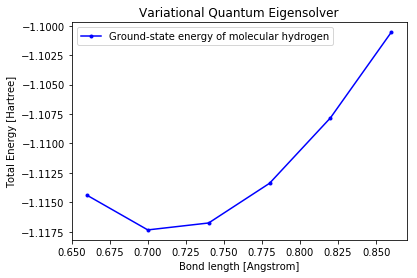

In [24]:
printed_output.show()
# H2 sto-3g Nelder-Mead


In [ ]:
printed_output.show()

In [45]:
import numpy as np
from time import time as tm

correct_vccsd_energies = []
for i in range(0, 30, 2):
    correct_vccsd_energies.append(vccsd_energies[i])
print(molecular_details)
# plt.subplot(121)

plt.figure(0)
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Variational Quantum Eigensolver")
plt.plot(bond_lengths, correct_vccsd_energies, "o-",
         label="vccsd ground energy")
plt.plot(bond_lengths, psi4_ccsd_energies, "+-",
         label="Psi4 ccsd ground energy")
plt.plot(bond_lengths, evals_ham_matrix, "g^--",
         label="Hamiltonian matrix")
plt.legend()
plt.axis('tight')
# plt.show()
fname = molecular_details + '_differential-evolution'
plt.savefig(fname, format='svg')

plt.figure(1)
plt.plot(bond_lengths, times, 'x-')
plt.ylabel('Optimisation time in seconds')
plt.xlabel('Bond length in angstrom')
plt.axis('tight')
# plt.show()
fname_t = fname + '_time'
plt.savefig(fname_t, format='svg')



H2_sto-3g_singlet_


/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [30]:
# molecule parameters.
basis = '6-21g'
multiplicity = 1
bond_length = 0.5
bond_lengths += [bond_length]
geometry = [('H', (0., 0., 0.)), 
            ('H', (0., 0., bond_length)),]
molecule = MolecularData(
    geometry, basis, multiplicity,
    description=str(round(bond_length, 2)))
print(f"#qubits (spin orbitals) in {basis} basis: {molecule.n_orbitals}")

#qubits (spin orbitals) in 6-21g basis: None


In [19]:
def my_jordan_wigner(fermion_op):
    qubit_op = jordan_wigner(fermion_op)
    good_qop = QubitOperator()
    for term in qubit_op.terms:
        good_qop += QubitOperator(term, qubit_op.terms[term])
    return good_qop

# Load data from computations done earlier
molecular_details = 'H2_sto-3g_singlet_'
datafile = molecular_details + 'data.npz'
data = np.load(datafile)

# unpack data
bond_lengths = data['bond_lengths']
evals_ham_matrix = data['evals_ham_matrix']
evect_ham_matrix= data['evect_ham_matrix']
psi4_ccsd_energies = data['psi4_ccsd_energies']
vccsd_energies = data['vccsd_energies']
vccsd_amplitudes = data['vccsd_amplitudes']
opt_times = data['opt_times']

# get psi4 classical data
folder = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/'

# for i in range(len(bond_lengths)):
file_i = folder + molecular_details + str(bond_lengths[0])
print(file_i)

# Load data from HDF5 computed using Openfermion-Psi4
molecule = MolecularData(filename=file_i)
molecule_qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

# for i in molecule_qubit_hamiltonian.terms:
#     print(i)
molecule_qubit_hamiltonian.terms[()] = molecule_qubit_hamiltonian.terms[()] - 0.8535116267580645
print(molecule_qubit_hamiltonian)


print(vccsd_energies[0])
print(psi4_ccsd_energies[0])

/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/H2_sto-3g_singlet_0.62
(-0.7609563312317935+0j) [] +
(-0.0436885077718617+0j) [X0 X1 Y2 Y3] +
(0.0436885077718617+0j) [X0 Y1 Y2 X3] +
(0.0436885077718617+0j) [Y0 X1 X2 Y3] +
(-0.0436885077718617+0j) [Y0 Y1 X2 X3] +
(0.1912322247203572+0j) [Z0] +
(0.17439448224256082+0j) [Z0 Z1] +
(0.12759488305882694+0j) [Z0 Z2] +
(0.17128339083068864+0j) [Z0 Z3] +
(0.19123222472035722+0j) [Z1] +
(0.17128339083068864+0j) [Z1 Z2] +
(0.12759488305882694+0j) [Z1 Z3] +
(-0.2868971878442727+0j) [Z2] +
(0.18013522745803243+0j) [Z2 Z3] +
(-0.2868971878442727+0j) [Z3]
-1.1069303672569721
-1.12276717160584


In [ ]:
IIII	(-0.760956329741821+0j)
IIIZ	(0.19123222520306998+0j)
IIZI	(-0.28689718948787934+0j)
IZII	(0.19123222520306996+0j)
ZIII	(-0.28689718948787934+0j)
IIZZ	(0.12759488321856435+0j)
IZIZ	(0.17439448237120006+0j)
XXYY	(0.043688507736669935+0j)
YYYY	(0.043688507736669935+0j)
XXXX	(0.043688507736669935+0j)
YYXX	(0.043688507736669935+0j)
ZIIZ	(0.17128339095523432+0j)
IZZI	(0.17128339095523432+0j)
ZIZI	(0.18013522759264217+0j)
ZZII	(0.12759488321856435+0j)